# Importation des données

In [ ]:
import warnings

# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
df = pd.read_csv("filtered_df.csv")

In [ ]:
selected_columns = ['text_1', 'cleaned_tags','checked']

num_rows = 10000


subset = df[selected_columns].sample(n=num_rows, random_state=42).copy()

import pandas as pd
# Convert the 'text_1' column to text type
subset['text_1'] = subset['text_1'].astype(str)

# Prétraitement des données textuelles et des balises pour la classification multi-étiquettes

In [ ]:
tags_list = [['c#'],
             ['java'],
             ['.net'],
             ['c++'],
             ['python'],
             ['javascript'],
             ['php'],
             ['asp.net'],
             ['sql'],
             ['c'],
             ['html'],
             ['sql-server'],
             ['jquery'],
             ['windows'],
             ['css'],
             ['iphone'],
             ['performance'],
             ['mysql'],
             ['algorithm'],
             ['visual-studio']]

In [ ]:
# Extract the 'checked' column as a list
labels_list =  subset['checked'].tolist()

# Split each label into a list
label_lists = [labels.split() for labels in labels_list]

In [ ]:
y=  subset['checked']

In [ ]:
from itertools import chain
import ast
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

X = subset['text_1']
X = X.astype(str)
# Flatten the tags_list into a single list
flattened_tags_list = list(chain.from_iterable(tags_list))

# TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="word", max_df=0.6, min_df=0.005)
X_tfidf = vectorizer.fit_transform(X)
print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer(classes=flattened_tags_list)
y_binarized = multilabel_binarizer.fit_transform(label_lists)
print("Shape of y: {}".format(y_binarized.shape))


Shape of X for Full_doc: (10000, 1324)
Shape of y: (10000, 20)


In [ ]:
# Obtenir les noms des mots
feature_names = vectorizer.get_feature_names_out()
tfidf1_data = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

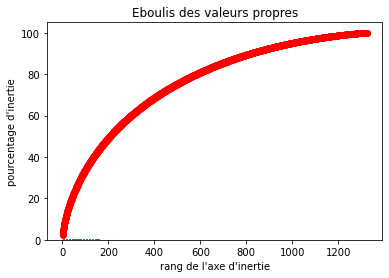

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(random_state=42)
pca.fit(tfidf1_data)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

A défaut d’un coude significatif dans la visualisation l’éboulis des composantes principales, nous utilisons un hyper paramètre consistant à retenir un nombre de vecteurs permettant de conserver 85% d’inertie.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.85, random_state=42)
X_tfidf = pca.fit_transform(tfidf1_data)


In [ ]:
subset['BinaryLabels']= y_binarized.tolist()
subset['BinaryLabels']

4216     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14770    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13208    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
25531    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
32813    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
4563     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
25102    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2051     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
13649    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3073     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
Name: BinaryLabels, Length: 10000, dtype: object

In [ ]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))


X_train shape: (8000, 1324)
X_test shape: (2000, 1324)
y_train shape: (8000, 20)
y_test shape: (2000, 20)


In [ ]:
labels = multilabel_binarizer.classes_
print(labels)


['c#' 'java' '.net' 'c++' 'python' 'javascript' 'php' 'asp.net' 'sql' 'c'
 'html' 'sql-server' 'jquery' 'windows' 'css' 'iphone' 'performance'
 'mysql' 'algorithm' 'visual-studio']


In [ ]:
# Save TfidfVectorizer and MultiLabelBinarizer
with open("vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

with open("binarizer.pkl", "wb") as file:
    pickle.dump(multilabel_binarizer, file)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary

    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filled with models ones
    """
    accuracy = accuracy_score(test_labels, predictions)
    jaccard_coeff = jaccard_score(test_labels, predictions, average='weighted')
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')

    performances[model_name] = {
        "accuracy": accuracy,
        "jaccard_coeff": jaccard_coeff,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    return performances

# Logistic Regression

In [ ]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Initialize Logistic Regression with OneVsRest
param_logit = {
    "estimator__C": [100, 10, 1.0, 0.1],
    "estimator__penalty": ["l1", "l2"],
    "estimator__dual": [False],
    "estimator__solver": ["liblinear"]
}

multi_logit_cv = GridSearchCV(
    OneVsRestClassifier(LogisticRegression()),
    param_grid=param_logit,
    n_jobs=-1,
    cv=5,
    scoring="f1_weighted",
    return_train_score=True,
    refit=True
)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
# Save the best model with pickle
best_logit_model = multi_logit_cv.best_estimator_
with open("best_logit_model.pkl", "wb") as f:
    pickle.dump(best_logit_model, f)

# RandomForest

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Initialize RandomForest with OneVsRest
param_rfc = {
    "estimator__max_depth": [5, 25, 50],
    "estimator__min_samples_leaf": [1, 5, 10],
    "estimator__class_weight": ["balanced"]
}

multi_rfc_cv = GridSearchCV(
    OneVsRestClassifier(RandomForestClassifier()),
    param_grid=param_rfc,
    n_jobs=-1,
    cv=2,
    scoring="f1_weighted",
    return_train_score=True,
    refit=True,
    verbose=3
)
multi_rfc_cv.fit(X_train, y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [ ]:
# Save the best model with pickle
best_rfc_model = multi_rfc_cv.best_estimator_
with open("best_model_rfc.pkl", "wb") as f:
    pickle.dump(best_rfc_model, f)

# LinearSVC

In [ ]:
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Initialize LinearSVC with OneVsRest
param_svc = {
    "estimator__C": [0.1, 1.0, 10.0],
    "estimator__penalty": ["l1", "l2"],
    "estimator__dual": [False],
    "estimator__loss": ["squared_hinge"],
    "estimator__max_iter": [1000, 2000, 5000]
}

multi_svc_cv = GridSearchCV(
    OneVsRestClassifier(LinearSVC(max_iter=1000)),
    param_grid=param_svc,
    n_jobs=-1,
    cv=2,
    scoring="f1_weighted",
    return_train_score=True,
    refit=True,
    verbose=3
)
multi_svc_cv.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1.0, 10.0],
                         'estimator__dual': [False],
                         'estimator__loss': ['squared_hinge'],
                         'estimator__max_iter': [1000, 2000, 5000],
                         'estimator__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [ ]:
# Save the best model with pickle
best_svc_model = multi_svc_cv.best_estimator_
with open("best_model_svc.pkl", "wb") as f:
    pickle.dump(best_svc_model, f)

# évaluer les performances

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model_name, model, X_test, y_test, performances):
    """
    Make predictions using the trained model and evaluate its performance using metrics_report.

    Args:
        model_name (str): Name of the model.
        model: The trained model object.
        X_test: Testing data.
        y_test: Testing labels.
        performances (dict): Dictionary to store performance metrics.

    Returns:
        performances (dict): Updated dictionary with model performance metrics.
    """
    predictions = model.predict(X_test)
    performances = metrics_report(model_name, y_test, predictions, performances)
    return performances

In [ ]:
# Create an empty dictionary to store performance metrics
performances = {}

# Evaluate Logistic Regression model
performances = evaluate_model("Logistic Regression",multi_logit_cv.best_estimator_, X_test, y_test, performances)

# Evaluate Random Forest model
performances = evaluate_model("Random Forest", multi_rfc_cv, X_test, y_test, performances)

# Evaluate Support Vector Machine model
performances = evaluate_model("Support Vector Machine", multi_svc_cv.best_estimator_, X_test, y_test, performances)

# Print the performance metrics for all models
print(performances)

{'Logistic Regression': {'accuracy': 0.464, 'jaccard_coeff': 0.4350686492576185, 'precision': 0.6515336069303813, 'recall': 0.539, 'f1': 0.5888334781347443}, 'Random Forest': {'accuracy': 0.4265, 'jaccard_coeff': 0.5078723736892645, 'precision': 0.6096519311931533, 'recall': 0.7425, 'f1': 0.6581772336253358}, 'Support Vector Machine': {'accuracy': 0.4765, 'jaccard_coeff': 0.4513095949789377, 'precision': 0.7407524177756187, 'recall': 0.5135, 'f1': 0.6026918003019488}}


In [ ]:
# Convert the performance metrics dictionary to a DataFrame table
df_performances = pd.DataFrame.from_dict(performances, orient='index')

# Display the DataFrame table
print(df_performances)

                        accuracy  jaccard_coeff  precision  recall        f1
Logistic Regression       0.4640       0.435069   0.651534  0.5390  0.588833
Random Forest             0.4265       0.507872   0.609652  0.7425  0.658177
Support Vector Machine    0.4765       0.451310   0.740752  0.5135  0.602692


In [ ]:
import numpy as np

def show_non_predicted_tags(model_name, model,X_test):
    """
    Calculate the percentage of non-tagged questions for a given model.

    Args:
        model_name (str): Name of the model.
        model: The trained model object.
        y_test: Testing labels.

    Returns:
        null_rate (float): Percentage of non-tagged questions for the model.
    """
    y_pred = model.predict(X_test)

    Tags_per_row = y_pred.sum(axis=1)
    null_rate = round(((Tags_per_row.size - np.count_nonzero(Tags_per_row))
                      / Tags_per_row.size) * 100, 2)

    print("-" * 50)
    print("Percentage of non-tagged questions for {} model".format(model_name))
    print("-" * 50)
    print("{}: {}%".format(model_name, null_rate))
    print()

    return null_rate


In [ ]:
# Create an empty list to store the results
results = []

# Call the function for each model and store the results in the list
results.append(('Random Forest', show_non_predicted_tags("Random Forest", multi_rfc_cv.best_estimator_, X_test)))
results.append(('Support Vector Machine', show_non_predicted_tags("Support Vector Machine", multi_svc_cv.best_estimator_, X_test)))
results.append(('Logistic Regression', show_non_predicted_tags("Logistic Regression", multi_logit_cv.best_estimator_, X_test)))
# Print the results list
for model, null_rate in results:
    print(f'{model}: {null_rate}%')

--------------------------------------------------
Percentage of non-tagged questions for Random Forest model
--------------------------------------------------
Random Forest: 10.3%

--------------------------------------------------
Percentage of non-tagged questions for Support Vector Machine model
--------------------------------------------------
Support Vector Machine: 36.4%

--------------------------------------------------
Percentage of non-tagged questions for Logistic Regression model
--------------------------------------------------
Logistic Regression: 27.6%



Effectuer une transformation inverse sur les prédictions et les véritables étiquettes, puis d'afficher les étiquettes prédites et les véritables étiquettes

In [ ]:
def predict_and_inverse_transform(model_name, model, X_test, y_test, multilabel_binarizer):
    # Predict labels for the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predicted labels
    predicted_labels = multilabel_binarizer.inverse_transform(y_pred)

    # Inverse transform the true labels
    true_labels = multilabel_binarizer.inverse_transform(y_test)

    # Print the predicted and true labels side by side
    for predicted, true in zip(predicted_labels, true_labels):
        print(f"Predicted: {predicted} | True: {true}")

In [ ]:
predict_and_inverse_transform("Random Forest", multi_rfc_cv, X_test, y_test, multilabel_binarizer)

Predicted: ('php',) | True: ('php',)
Predicted: ('c#', 'sql') | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c#',) | True: ('.net',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('sql',) | True: ('sql',)
Predicted: ('sql',) | True: ('sql',)
Predicted: ('javascript', 'html') | True: ('html',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('mysql',) | True: ('mysql',)
Predicted: ('sql', 'html') | True: ('html',)
Predicted: ('c++',) | True: ('algorithm',)
Predicted: ('java',) | True: ('javascript',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#',) | True: ('sql',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('javascript', 'html') | True: ('html',)
Predicted: ('javascript', 'html', 'jquery', 'css') | True: ('javascript',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#', 'asp.

Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('python',) | True: ('python',)
Predicted: ('javascript',) | True: ('javascript',)
Predicted: () | True: ('.net',)
Predicted: ('c++', 'c') | True: ('c',)
Predicted: ('java',) | True: ('iphone',)
Predicted: ('javascript',) | True: ('html',)
Predicted: () | True: ('c#',)
Predicted: ('c#', 'java', '.net') | True: ('java',)
Predicted: ('python',) | True: ('python',)
Predicted: ('javascript',) | True: ('javascript',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('python',) | True: ('python',)
Predicted: ('javascript', 'jquery') | True: ('jquery',)
Predicted: ('java',) | True: ('java',)
Predicted: ('c#', '.net') | True: ('.net',)
Predicted: () | True: ('asp.net',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#',) | True: ('iphone',)
Predicted: ('c#', 'c++') | True: ('c',)
Predicted: () | True: ('algorithm',)
Predicted: ('c#', 'c++') | True: ('c#',)
Predicted: ('c#', '.net') | True: ('c#',)
Predicted: ('ht

Predicted: ('c++', 'windows') | True: ('c',)
Predicted: ('java',) | True: ('java',)
Predicted: ('sql',) | True: ('sql-server',)
Predicted: ('python',) | True: ('python',)
Predicted: ('javascript',) | True: ('javascript',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#', 'sql') | True: ('sql',)
Predicted: ('java',) | True: ('java',)
Predicted: ('python',) | True: ('python',)
Predicted: ('c++',) | True: ('java',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('php',) | True: ('php',)
Predicted: ('sql', 'sql-server') | True: ('sql-server',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('iphone',) | True: ('iphone',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++', 'html') | True: ('html',)
Predicted: ('java', 'c++') | True: ('java',)
Predicted: ('c++', 'windows') | True: ('c',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('c',)
Predicted: ('c#', 'c++') | True: ('php',)
Predicted: () | True: ('sql',)
Predicted: ('python',) | True: ('python',)
Predicted: ('c#'

In [ ]:
predict_and_inverse_transform("LinearSVC", multi_svc_cv.best_estimator_, X_test, y_test, multilabel_binarizer)

Predicted: ('php',) | True: ('php',)
Predicted: ('sql',) | True: ('c#',)
Predicted: () | True: ('java',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c#',) | True: ('.net',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('sql',) | True: ('sql',)
Predicted: () | True: ('sql',)
Predicted: ('html',) | True: ('html',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('mysql',) | True: ('mysql',)
Predicted: () | True: ('html',)
Predicted: () | True: ('algorithm',)
Predicted: ('java',) | True: ('javascript',)
Predicted: ('c#', 'java') | True: ('c#',)
Predicted: () | True: ('sql',)
Predicted: () | True: ('c#',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: () | True: ('html',)
Predicted: ('css',) | True: ('javascript',)
Predicted: ('c++',) | True: ('c++',)
Predicted: () | True: ('asp.net',)
Predicted: () | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: () | True: ('c

Predicted: ('.net',) | True: ('c#',)
Predicted: ('sql',) | True: ('sql',)
Predicted: () | True: ('iphone',)
Predicted: () | True: ('performance',)
Predicted: () | True: ('c#',)
Predicted: () | True: ('javascript',)
Predicted: ('java',) | True: ('java',)
Predicted: ('java',) | True: ('java',)
Predicted: () | True: ('c#',)
Predicted: () | True: ('javascript',)
Predicted: () | True: ('python',)
Predicted: ('asp.net',) | True: ('asp.net',)
Predicted: ('java',) | True: ('java',)
Predicted: ('jquery',) | True: ('javascript',)
Predicted: () | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('java',) | True: ('java',)
Predicted: () | True: ('c#',)
Predicted: ('python',) | True: ('python',)
Predicted: ('java',) | True: ('java',)
Predicted: () | True: ('c#',)
Predicted: ('php',) | True: ('php',)
Predicted: () | True: ('c++',)
Predicted: () | True: ('javascript',)
Predicted: () | True: ('c++',)
Predicted: () |

In [ ]:
predict_and_inverse_transform("Logistic Regression", multi_logit_cv.best_estimator_, X_test, y_test, multilabel_binarizer)

Predicted: ('php',) | True: ('php',)
Predicted: ('sql',) | True: ('c#',)
Predicted: ('c#', 'java') | True: ('java',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c#',) | True: ('.net',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('sql',) | True: ('sql',)
Predicted: () | True: ('sql',)
Predicted: ('html',) | True: ('html',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('mysql',) | True: ('mysql',)
Predicted: ('javascript',) | True: ('html',)
Predicted: ('c++',) | True: ('algorithm',)
Predicted: ('java',) | True: ('javascript',)
Predicted: ('c#', 'java') | True: ('c#',)
Predicted: () | True: ('sql',)
Predicted: () | True: ('c#',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#', '.net') | True: ('c#',)
Predicted: ('html',) | True: ('html',)
Predicted: ('css',) | True: ('javascript',)
Predicted: ('c++',) | True: ('c++',)
Predicted: () | True: ('asp.net',)
Predicted: () | True: ('c#',)
Predicted: ('c++'

Predicted: ('java',) | True: ('java',)
Predicted: ('c#',) | True: ('c#',)
Predicted: () | True: ('c#',)
Predicted: () | True: ('javascript',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('.net',) | True: ('c#',)
Predicted: ('sql',) | True: ('sql',)
Predicted: () | True: ('iphone',)
Predicted: ('c#',) | True: ('performance',)
Predicted: ('c++',) | True: ('c#',)
Predicted: () | True: ('javascript',)
Predicted: ('java',) | True: ('java',)
Predicted: ('java',) | True: ('java',)
Predicted: () | True: ('c#',)
Predicted: () | True: ('javascript',)
Predicted: () | True: ('python',)
Predicted: ('asp.net',) | True: ('asp.net',)
Predicted: ('java',) | True: ('java',)
Predicted: ('jquery',) | True: ('javascript',)
Predicted: () | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('java',) | True: ('java',)
Predicted: ('.net',) | True: ('c#',)
Predicted: ('python',) | True:

# Universal Sentence Encoder (use) with MLPClassifier

In [ ]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(model_url)



In [ ]:
import pandas as pd
import tensorflow as tf
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import chain

# Preprocess your data
subset['text_1'] = subset['text_1'].astype(str)

X = subset['text_1']

X = X.astype(str)

# Flatten the tags_list into a single list and remove duplicates
flattened_tags_list = list(set(chain.from_iterable(tags_list)))

# Encode sentences using USE
X_encoded = use_model(X)

# Convert tags to binary labels
multilabel_binarizer = MultiLabelBinarizer(classes=flattened_tags_list)
y_encoded = multilabel_binarizer.fit_transform(label_lists)

X_encoded = np.array(X_encoded)
y_encoded = np.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Define and train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=200, random_state=42)
mlp_classifier.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(256, 128), random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Predict labels for the test set
y_pred = mlp_classifier.predict(X_test)

# Inverse transform the predicted and true labels
y_pred_inverse = multilabel_binarizer.inverse_transform(y_pred)
y_test_inverse = multilabel_binarizer.inverse_transform(y_test)

In [ ]:
# Evaluate mlp_classifier
performances = evaluate_model(" mlp_classifier",  mlp_classifier, X_test, y_test, performances)

# Print the performance metrics for all models
print(performances)

{'Logistic Regression': {'accuracy': 0.464, 'jaccard_coeff': 0.4350686492576185, 'precision': 0.6515336069303813, 'recall': 0.539, 'f1': 0.5888334781347443}, 'Random Forest': {'accuracy': 0.4265, 'jaccard_coeff': 0.5078723736892645, 'precision': 0.6096519311931533, 'recall': 0.7425, 'f1': 0.6581772336253358}, 'Support Vector Machine': {'accuracy': 0.4765, 'jaccard_coeff': 0.4513095949789377, 'precision': 0.7407524177756187, 'recall': 0.5135, 'f1': 0.6026918003019488}, ' mlp_classifier': {'accuracy': 0.591, 'jaccard_coeff': 0.5200123090360761, 'precision': 0.6835533265172234, 'recall': 0.64, 'f1': 0.6589924679272322}}


In [ ]:
results.append(('MLP Classifier', show_non_predicted_tags("MLP Classifier", mlp_classifier, X_test)))


--------------------------------------------------
Percentage of non-tagged questions for MLP Classifier model
--------------------------------------------------
MLP Classifier: 14.25%



In [ ]:
predict_and_inverse_transform(" mlp_classifier",  mlp_classifier, X_test, y_test,multilabel_binarizer)

Predicted: ('php',) | True: ('php',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('php',) | True: ('php',)
Predicted: ('c#',) | True: ('.net',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('php',) | True: ('sql',)
Predicted: ('sql',) | True: ('sql',)
Predicted: ('html',) | True: ('html',)
Predicted: ('php',) | True: ('php',)
Predicted: () | True: ('c++',)
Predicted: ('mysql',) | True: ('mysql',)
Predicted: () | True: ('html',)
Predicted: ('algorithm',) | True: ('algorithm',)
Predicted: ('java',) | True: ('javascript',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#',) | True: ('sql',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('html',) | True: ('html',)
Predicted: () | True: ('javascript',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('asp.net',) | True: ('asp.net',)
Predicted: ('.net',) | True: ('c#',)
Predicted: ('c++',) | T

Predicted: ('c++',) | True: ('c#',)
Predicted: ('asp.net', 'c#') | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('python',) | True: ('python',)
Predicted: () | True: ('.net',)
Predicted: () | True: ('algorithm',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('c++',) | True: ('windows',)
Predicted: ('javascript',) | True: ('javascript',)
Predicted: ('.net',) | True: ('.net',)
Predicted: ('c++',) | True: ('.net',)
Predicted: () | True: ('javascript',)
Predicted: ('sql',) | True: ('sql',)
Predicted: () | True: ('c#',)
Predicted: ('c++',) | True: ('c#',)
Predicted: ('c#',) | True: ('c#',)
Predicted: ('java',) | True: ('java',)
Predicted: ('c++',) | True: ('c++',)
Predicted: ('asp.net',) | True: ('c#',)
Predicted: ('php',) | True: ('php',)
Predicted: ('iphone',) | True: ('iphone',)
Predicted: ('java',) | True: ('java',)
Predicted: ('python',) | True: ('python',)
Predicted: ('python',) | True: ('python',)
Predicted: () | True: ('performance',)
Predicted: ('c#',) | True: (

In [ ]:
# Print the results list
for model, null_rate in results:
    print(f'{model}: {null_rate}%')

Random Forest: 10.3%
Support Vector Machine: 36.4%
Logistic Regression: 27.6%
MLP Classifier: 14.25%


In [ ]:
# Convert the performance metrics dictionary to a DataFrame table
df_performances = pd.DataFrame.from_dict(performances, orient='index')

# Display the DataFrame table
print(df_performances)

                        accuracy  jaccard_coeff  precision  recall        f1
Logistic Regression       0.4640       0.435069   0.651534  0.5390  0.588833
Random Forest             0.4265       0.507872   0.609652  0.7425  0.658177
Support Vector Machine    0.4765       0.451310   0.740752  0.5135  0.602692
 mlp_classifier           0.5910       0.520012   0.683553  0.6400  0.658992


In [ ]:
df_performances['empty_tags'] = [27.6, 10.3, 36.4, 14.25]

In [ ]:
df_performances

,accuracy,jaccard_coeff,precision,recall,f1,empty_tags
Logistic Regression,0.4640,0.435069,0.651534,0.5390,0.588833,27.60
Random Forest,0.4265,0.507872,0.609652,0.7425,0.658177,10.30
Support Vector Machine,0.4765,0.451310,0.740752,0.5135,0.602692,36.40
mlp_classifier,0.5910,0.520012,0.683553,0.6400,0.658992,14.25


In [ ]:
df_performances.to_csv('df_performances.csv')

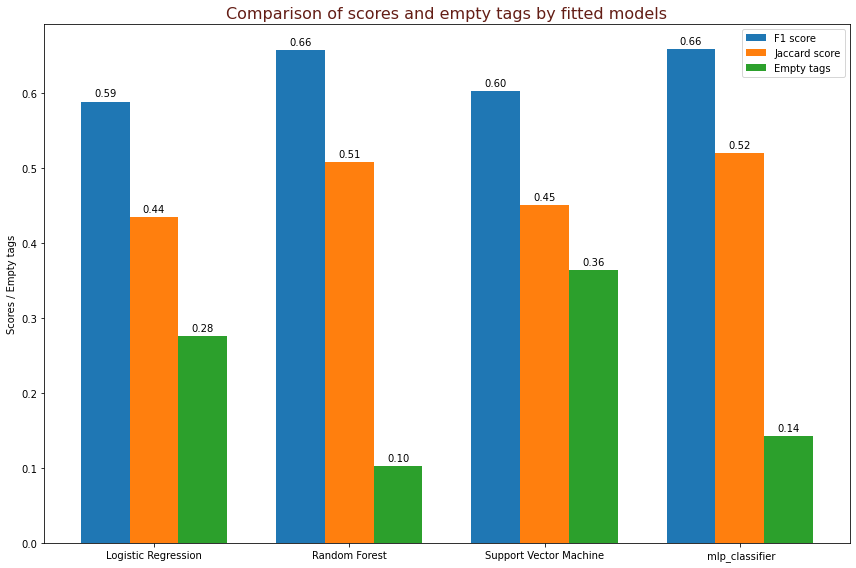

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the data for plotting
x = np.arange(len(df_performances.index))
width = 0.25
f1_scores = df_performances['f1']
jacc_scores = df_performances['jaccard_coeff']
empty_tags = df_performances['empty_tags']/ 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bars for F1 score, Jaccard score, and empty tags
ax.bar(x - width, f1_scores, width, label="F1 score")
ax.bar(x, jacc_scores, width, label="Jaccard score")
ax.bar(x + width, empty_tags, width, label="Empty tags")

# Set the y-axis label and title for the plot
ax.set_ylabel('Scores / Empty tags')
ax.set_title('Comparison of scores and empty tags by fitted models',
             color="#641E16",
             fontdict={'fontsize': 16})

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(df_performances.index)

# Set the legend
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    """Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.containers[0])
autolabel(ax.containers[1])
autolabel(ax.containers[2])

# Adjust the layout
fig.tight_layout()

# Show the plot
plt.show()


Le modele sélectionné pour notre problématique de proposition de Tags Stockoverflow est : Random Forest

# LDA MODEL

l'approche LDA pour extraire des sujets à partir d'un ensemble de textes prétraités. Il explore différents nombres de sujets et évalue la cohérence des sujets extraits. L'objectif est de déterminer le nombre optimal de sujets qui donne les meilleurs résultats de cohérence pour la classification des textes par sujets.

Fitting LDA for num_topics = 2
Fitting LDA for num_topics = 3
Fitting LDA for num_topics = 4
Fitting LDA for num_topics = 5
Fitting LDA for num_topics = 6
Fitting LDA for num_topics = 7
Fitting LDA for num_topics = 8
Fitting LDA for num_topics = 9
Fitting LDA for num_topics = 10
Fitting LDA for num_topics = 11
Fitting LDA for num_topics = 12


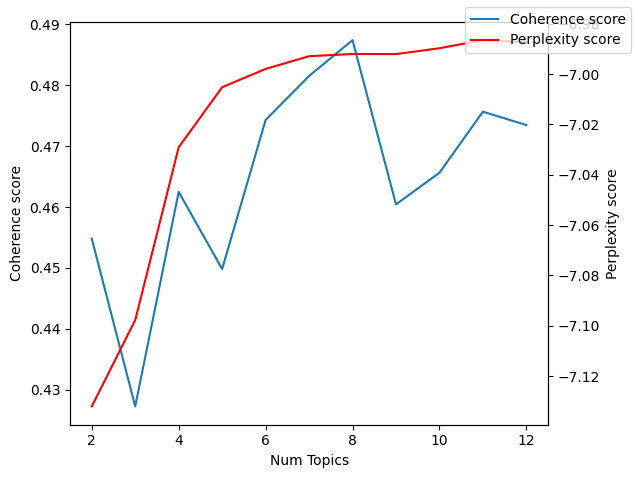

Num Topics = 2  has Coherence Value of 0.4548 and Perplexity Value of -7.1321
Num Topics = 3  has Coherence Value of 0.4272 and Perplexity Value of -7.0978
Num Topics = 4  has Coherence Value of 0.4625 and Perplexity Value of -7.0291
Num Topics = 5  has Coherence Value of 0.4498 and Perplexity Value of -7.0053
Num Topics = 6  has Coherence Value of 0.4743 and Perplexity Value of -6.998
Num Topics = 7  has Coherence Value of 0.4815 and Perplexity Value of -6.9929
Num Topics = 8  has Coherence Value of 0.4874 and Perplexity Value of -6.9921
Num Topics = 9  has Coherence Value of 0.4604 and Perplexity Value of -6.9921
Num Topics = 10  has Coherence Value of 0.4656 and Perplexity Value of -6.9898
Num Topics = 11  has Coherence Value of 0.4756 and Perplexity Value of -6.9866
Num Topics = 12  has Coherence Value of 0.4734 and Perplexity Value of -6.9874


In [ ]:
import logging
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore
from gensim.utils import simple_preprocess

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)


def create_dictionary(texts):
    """
    Create a dictionary (bag of words) from the input texts.

    Args:
        texts: List of input texts.

    Returns:
        id2word: Gensim dictionary.
    """
    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
    return id2word


def create_corpus(texts, dictionary):
    """
    Create a corpus using the given texts and dictionary.

    Args:
        texts: List of input texts.
        dictionary: Gensim dictionary.

    Returns:
        corpus: Gensim corpus.
    """
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus


def compute_coherence_perplexity_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence and perplexity scores for various number of topics.

    Args:
        dictionary: Gensim dictionary.
        corpus: Gensim corpus.
        texts: List of input texts.
        limit: Max number of topics.
        start: Starting number of topics (default: 2).
        step: Step size for number of topics (default: 1).

    Returns:
        model_list: List of LDA topic models.
        coherence_values: Coherence values corresponding to the LDA model with respective number of topics.
        perplexity_values: Perplexity values corresponding to the LDA model with respective number of topics.
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Fitting LDA for num_topics =", num_topics)
        lda_model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=8,
            passes=10,
            workers=4
        )
        model_list.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))
    return model_list, coherence_values, perplexity_values


def plot_coherence_perplexity_values(start, limit, step, coherence_values, perplexity_values):
    """
    Plot the coherence and perplexity values.

    Args:
        start: Starting number of topics.
        limit: Max number of topics.
        step: Step size for number of topics.
        coherence_values: Coherence values corresponding to the LDA model with respective number of topics.
        perplexity_values: Perplexity values corresponding to the LDA model with respective number of topics.

    Returns:
        None
    """
    x = range(start, limit, step)
    fig, ax1 = plt.subplots()
    ax1.plot(x, coherence_values, label="Coherence score")
    ax1.set_xlabel("Num Topics")
    ax1.set_ylabel("Coherence score")
    ax2 = ax1.twinx()
    ax2.plot(x, perplexity_values, color='red', label="Perplexity score")
    ax2.set_ylabel("Perplexity score")
    fig.tight_layout()
    fig.legend(loc='upper right')
    plt.show()


def print_coherence_perplexity_scores(start, limit, step, coherence_values, perplexity_values):
    """
    Print the coherence and perplexity scores.

    Args:
        start: Starting number of topics.
        limit: Max number of topics.
        step: Step size for number of topics.
        coherence_values: Coherence values corresponding to the LDA model with respective number of topics.
        perplexity_values: Perplexity values corresponding to the LDA model with respective number of topics.

    Returns:
        None
    """
    for num_topics, cv, perplexity in zip(range(start, limit, step), coherence_values, perplexity_values):
        print("Num Topics =", num_topics, " has Coherence Value of", round(cv, 4), "and Perplexity Value of",
              round(perplexity, 4))


# Define X1 as a list of lists
X1 = [text.split() for text in subset['text_1'].copy()]

# Create dictionary
id2word = create_dictionary(X1)

# Create Corpus
corpus = create_corpus(X1, id2word)

# Compute coherence and perplexity values
model_list, coherence_values, perplexity_values = compute_coherence_perplexity_values(
    dictionary=id2word,
    corpus=corpus,
    texts=X1,
    start=2,
    limit=13,
    step=1
)

# Plot coherence and perplexity values
plot_coherence_perplexity_values(start=2, limit=13, step=1, coherence_values=coherence_values,
                                 perplexity_values=perplexity_values)

# Print coherence and perplexity scores
print_coherence_perplexity_scores(start=2, limit=13, step=1, coherence_values=coherence_values,
                                  perplexity_values=perplexity_values)


In [ ]:
import numpy as np
import pandas as pd

def print_topic_keywords(lda_model, num_top_keywords=10):
    """
    Print the top keywords for each topic in the given LDA model.

    Args:
        lda_model: Trained LDA model.
        num_top_keywords: Number of top keywords to display for each topic (default: 10).

    Returns:
        None
    """
    topic_names = ["Topic" + str(i) for i in range(lda_model.num_topics)]
    topic_keywords = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_top_keywords, formatted=False)

    print("-" * 50)
    print("Top Keywords for Each Topic")
    print("-" * 50)
    for topic in topic_keywords:
        topic_id = topic[0]
        keywords = [word for word, _ in topic[1]]
        print(f"Topic {topic_id}:")
        print(", ".join(keywords))
        print()

optimal_num_topics = 8

lda_best = model_list[optimal_num_topics - 2]

print_topic_keywords(lda_best, num_top_keywords=10)

--------------------------------------------------
Top Keywords for Each Topic
--------------------------------------------------
Topic 0:
c, use, int, code, way, number, would, like, array, value

Topic 1:
table, use, sql, query, -PRON-, select, row, d, database, value

Topic 2:
class, public, object, method, use, c, new, return, void, string

Topic 3:
use, file, net, java, application, server, get, web, page, php

Topic 4:
lt, gt, test, text, string, list, return, name, class, value

Topic 5:
c, use, code, file, like, would, work, get, python, exception

Topic 6:
system, window, use, code, new, user, object, application, event, file

Topic 7:
gt, lt, div, quot, -PRON-, d, td, type, html, value



In [ ]:
import logging
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore
from gensim.utils import simple_preprocess

def create_dictionary(texts):
    """
    Create a dictionary (bag of words) from the input texts.

    Args:
        texts: List of input texts.

    Returns:
        id2word: Gensim dictionary.
    """
    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
    return id2word


def create_corpus(texts, dictionary):
    """
    Create a corpus using the given texts and dictionary.

    Args:
        texts: List of input texts.
        dictionary: Gensim dictionary.

    Returns:
        corpus: Gensim corpus.
    """
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus
# Define X1 as a list of lists
X1 = [text.split() for text in subset['text_1'].copy()]

# Create dictionary
id2word = create_dictionary(X1)


# Create Corpus
corpus = create_corpus(X1, id2word)

In [ ]:
import gensim
num_topics = 8
# Best LDA visualization
# Construire le modèle LDA
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  passes=10,
                                      iterations=200,
                                  workers=4)


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
# Convert lda_model to pyLDAvis format
lda_display = gensimvis.prepare(lda_model, corpus, id2word)

# Visualize the topic relationships
pyLDAvis.display(lda_display)

# NMF MODEL

In [ ]:
from sklearn.decomposition import NMF

def train_nmf_model(data, num_topics):
    """
    Train an NMF (Non-Negative Matrix Factorization) model on the given data.

    Args:
        data: Input data matrix.
        num_topics: Number of topics to extract.

    Returns:
        Trained NMF model.
    """
    nmf_model = NMF(n_components=num_topics, random_state=1, init='nndsvd')
    nmf_model.fit(data)
    return nmf_model

def display_topics(model, feature_names, num_top_words):
    """
    Display the top keywords for each topic in the given NMF model.

    Args:
        model: Trained NMF model.
        feature_names: List of feature names (column names).
        num_top_words: Number of top keywords to display for each topic.

    Returns:
        None
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Assuming `tfidf1_data` is the TF-IDF data used for NMF
num_topics = 8
nmf_model = train_nmf_model(tfidf1_data.values, num_topics)

# Assuming `k` is the list of column names in `tfidf1_data`
no_top_words = 10
display_topics(nmf_model, tfidf1_data.columns, no_top_words)


Topic 0:
use, function, javascript, python, code, like, would, php, way, page

Topic 1:
gt, lt, div, td, html, type, pron, text, name, tr

Topic 2:
class, public, method, object, static, void, type, foo, new, return

Topic 3:
table, sql, query, select, database, column, row, pron, server, mysql

Topic 4:
file, read, directory, path, line, xml, open, write, folder, text

Topic 5:
string, list, array, value, int, convert, return, quot, character, char

Topic 6:
java, library, use, language, good, lang, eclipse, jvm, jar, source

Topic 7:
net, application, asp, web, server, system, project, use, window, service



# BertTokenizer WITH Xgboost

In [ ]:
import torch
from transformers import BertTokenizer
import pandas as pd

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


input_ids_list = []
attention_masks_list = []

max_length = 128  # Set the desired maximum sequence length

# Iterate over each row in the DataFrame
for index, row in subset.iterrows():
    text = row['text_1']

    # Tokenize the text
    text_tokens = ['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]']

    # Truncate or pad sequences to max_length
    text_tokens = text_tokens[:max_length]

    # Convert tokens to token IDs
    text_token_ids = tokenizer.convert_tokens_to_ids(text_tokens)

    # Create attention masks
    text_attention_mask = [1] * len(text_token_ids)

    # Padding
    padding_length = max_length - len(text_token_ids)
    text_token_ids += [0] * padding_length
    text_attention_mask += [0] * padding_length

    # Append to the lists
    input_ids_list.append(text_token_ids)
    attention_masks_list.append(text_attention_mask)

# Convert lists to tensors
input_ids = torch.tensor(input_ids_list)
attention_masks = torch.tensor(attention_masks_list)

In [ ]:
# Print the input tensors
print("Input IDs:", input_ids)
print("Attention Masks:", attention_masks)

Input IDs: tensor([[  101,  2131,  2197,  ...,     0,     0,     0],
        [  101,  3191,  3200,  ...,     0,     0,     0],
        [  101,  2411, 28616,  ...,     0,     0,     0],
        ...,
        [  101,  2215,  8816,  ...,     0,     0,     0],
        [  101,  6097,  4769,  ...,     0,     0,     0],
        [  101, 16755,  1043,  ...,     0,     0,     0]])
Attention Masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
# Split the input data and labels
X = input_ids
y = label_lists
# Convert tags to binary labels
multilabel_binarizer = MultiLabelBinarizer(classes=flattened_tags_list)
y_encoded = multilabel_binarizer.fit_transform(label_lists)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from sklearn.metrics import log_loss, accuracy_score

NUM_CLASSES = 20

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV
# Flatten the one-hot encoded multi-labels into a single vector
y_train_single = (y_train * np.arange(NUM_CLASSES)).sum(axis=1)
y_test_single = (y_test * np.arange(NUM_CLASSES)).sum(axis=1)

# Convert the input_ids to a format suitable for XGBoost (DMatrix)
dtrain = xgb.DMatrix(X_train.reshape(X_train.shape[0], -1), label=y_train_single)
dtest = xgb.DMatrix(X_test.reshape(X_test.shape[0], -1), label=y_test_single)

# Define the hyperparameters for the grid search
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb.XGBClassifier(objective='multi:softprob', num_class=NUM_CLASSES), param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train_single)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the XGBoost model with the best hyperparameters
xgb_model = xgb.train(best_params, dtrain, num_boost_round=num_boost_round)

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}

In [ ]:
# Set the XGBoost parameters
params = {
    'objective': 'multi:softprob',  # For multi-label classification
    'num_class': NUM_CLASSES,       # Specify the number of classes
    'learning_rate': 0.1,          # Learning rate for gradient boosting
    'max_depth': 5,                # Maximum depth of the trees
    'subsample': 0.8,              # Subsample ratio of the training instances
    # Add other XGBoost hyperparameters as needed
}

# Train the XGBoost model with the specified hyperparameters
num_boost_round = 100
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Make predictions on the test set (probabilities for each class)
test_probs = xgb_model.predict(dtest)

# Manually select the class label with the highest probability for each sample
test_preds = np.argmax(test_probs, axis=1)

# Calculate and print the evaluation metrics
print("Test LogLoss: {}".format(log_loss(y_test, test_probs)))
print("Test Accuracy: {}".format(accuracy_score(y_test_single, test_preds)))

# Calculate and print the F1 score and Jaccard coefficient
f1 = f1_score(y_test_single, test_preds, average='weighted')
jaccard = jaccard_score(y_test_single, test_preds, average='weighted')

print("Test F1 Score: {}".format(f1))
print("Test Jaccard Coefficient: {}".format(jaccard))

Test LogLoss: 1.940733664295994
Test Accuracy: 0.421
Test F1 Score: 0.3954348610863097
Test Jaccard Coefficient: 0.2662975513326591


In [ ]:
# Calculate precision and recall
precision = precision_score(y_test_single, test_preds, average='weighted')
recall = recall_score(y_test_single, test_preds, average='weighted')
print("Test Precision: {}".format(precision))
print("Test Recall: {}".format(recall))

Test Precision: 0.5130388725679591
Test Recall: 0.421


In [ ]:
 show_non_predicted_tags("Xgboost", xgb_model, dtest)

--------------------------------------------------
Percentage of non-tagged questions for Xgboost model
--------------------------------------------------
Xgboost: 0.0%



0.0

In [ ]:
# New row data
new_row = {
    'accuracy': 0.42,
    'jaccard_coeff': 0.26,
    'precision': 0.51,
    'recall': 0.421,
    'f1': 0.39,
    'empty_tags': 0.0,
}

# Adding the new row to the DataFrame
df_performances.loc['Xgboost with Bert'] = new_row

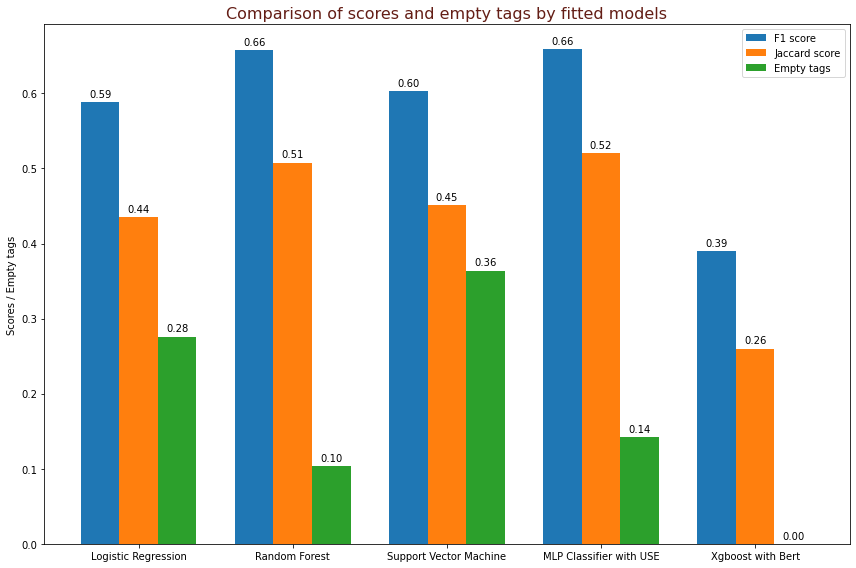

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the data for plotting
x = np.arange(len(df_performances.index))
width = 0.25
f1_scores = df_performances['f1']
jacc_scores = df_performances['jaccard_coeff']
empty_tags = df_performances['empty_tags']/ 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bars for F1 score, Jaccard score, and empty tags
ax.bar(x - width, f1_scores, width, label="F1 score")
ax.bar(x, jacc_scores, width, label="Jaccard score")
ax.bar(x + width, empty_tags, width, label="Empty tags")

# Set the y-axis label and title for the plot
ax.set_ylabel('Scores / Empty tags')
ax.set_title('Comparison of scores and empty tags by fitted models',
             color="#641E16",
             fontdict={'fontsize': 16})

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(df_performances.index)

# Set the legend
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    """Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.containers[0])
autolabel(ax.containers[1])
autolabel(ax.containers[2])

# Adjust the layout
fig.tight_layout()

# Show the plot
plt.show()